In [1]:
# # imports
# import psycopg2
import numpy as np
import pandas as pd
import json
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
from scipy import interpolate
from sklearn.impute import SimpleImputer
import pickle
import os

In [2]:
# access creds
with open('../psql_key.json') as file:
    creds = json.load(file)

# Create an SQLAlchemy engine with the PostgreSQL database URI
engine = create_engine(f"postgresql+psycopg2://{creds['user']}:{creds['password']}@{creds['host']}:{creds['port']}/{creds['database']}")

In [3]:
# these diag codes were taken from table mimiciv_hosp.d_icd_diagnoses
hf_codes = '''('39891','40200','40201','40210','40211','40290','40291','40400','40401','40402','40403','40410','40411','40412',
'40413','40490','40491','40492','40493','4280','4281','42820','42821','42822','42823','42830','42831','42832','42833','42840','42841',
'42842','42843','4289','E8726','E8745','I0981','I110','I119','I130','I131','I1310','I1311','I132','I50','I501','I502','I5020','I5021','I5022',
'I5023','I503','I5030','I5031','I5032','I5033','I504','I5040','I5041','I5042','I5043','I508','I5081','I50810','I50811','I50812','I50813','I50814',
'I5082','I5083','I5084','I5089','I509','I9713','I97130','I97131','T8622','T8632','Y625')'''

# get all admissions related to HF codes
query = f'''
select distinct a.subject_id , a.hadm_id , a.admittime , a.dischtime , p.gender , p.anchor_age , p.dod
from (select hadm_id from mimiciv_hosp.diagnoses_icd where icd_code in {hf_codes}) d
inner join (select * from mimiciv_hosp.admissions) a
on a.hadm_id = d.hadm_id
inner join (select * from mimiciv_hosp.patients) p
on p.subject_id = a.subject_id
'''

all_hf_pats_0 = pd.read_sql_query(query , engine)

all_hf_pats_0['dod'] = pd.to_datetime(all_hf_pats_0['dod']).dt.date
all_hf_pats_0['admittime'] = all_hf_pats_0['admittime'].dt.date
all_hf_pats_0['dischtime'] = all_hf_pats_0['dischtime'].dt.date

# Get online medical record data (OMR)
reqd_results = ("BMI (kg/m2)" , "Height (Inches)" , "Weight (Lbs)") # Not including BP as I can get it from vitalsigns  
q = f'''select * from mimiciv_hosp.omr where result_name in {reqd_results}'''

omr = pd.read_sql_query(q , engine)
# omr_pivot = pd.read_sql_query(q , engine)
omr_first = omr.sort_values(['subject_id' , 'chartdate'] , ascending = True).groupby(['subject_id' , 'result_name']).first().reset_index()
omr_pivot = omr_first.pivot(index = 'subject_id', columns = 'result_name' , values = 'result_value').reset_index()
omr_pivot.dropna(inplace = True)

# Join
all_hf_pats = pd.merge(all_hf_pats_0 , omr_pivot , on = 'subject_id' , how = 'inner')

# QC
print(all_hf_pats['subject_id'].nunique())
all_hf_pats.head(2)

15628


,subject_id,hadm_id,admittime,dischtime,gender,anchor_age,dod,BMI (kg/m2),Height (Inches),Weight (Lbs)
0,18591383,20057039,2183-06-21,2183-06-22,M,81,2185-04-04,21.1,66,131
1,18591383,23411231,2184-06-16,2184-07-02,M,81,2185-04-04,21.1,66,131


In [4]:
# RACE
q = '''
select subject_id , race , count(race) as c_race
from mimiciv_hosp.admissions
group by subject_id , race
order by c_race desc
'''

race_0 = pd.read_sql_query(q , engine)
race = race_0.groupby('subject_id').first().reset_index().drop('c_race' , axis = 1)

# QC
assert len(race) == race_0["subject_id"].nunique() , 'is not patient level table'

#QC 
assert race.groupby('subject_id').agg({'race':'nunique'}).sort_values('race' , ascending = False).iloc[0 , ][0] == 1 , 'multiple races'

race_broad = pd.DataFrame( [
    ('AMERICAN INDIAN/ALASKA NATIVE','NATIVE'),
    ( 'ASIAN','ASIAN'),
    ( 'ASIAN - ASIAN INDIAN','ASIAN'),
    ( 'ASIAN - CHINESE','ASIAN'),
    ( 'ASIAN - KOREAN','ASIAN'),
    ( 'ASIAN - SOUTH EAST ASIAN','ASIAN'),
    ( 'BLACK/AFRICAN','BLACK'),
    ( 'BLACK/AFRICAN AMERICAN','BLACK'),
    ( 'BLACK/CAPE VERDEAN','BLACK'),
    ( 'BLACK/CARIBBEAN ISLAND','BLACK'),
    ( 'HISPANIC OR LATINO','HISPANIC'),
    ( 'HISPANIC/LATINO - CENTRAL AMERICAN','HISPANIC'),
    ( 'HISPANIC/LATINO - COLUMBIAN','HISPANIC'),
    ( 'HISPANIC/LATINO - CUBAN','HISPANIC'),
    ( 'HISPANIC/LATINO - DOMINICAN','HISPANIC'),
    ( 'HISPANIC/LATINO - GUATEMALAN','HISPANIC'),
    ( 'HISPANIC/LATINO - HONDURAN','HISPANIC'),
    ( 'HISPANIC/LATINO - MEXICAN','HISPANIC'),
    ( 'HISPANIC/LATINO - PUERTO RICAN','HISPANIC'),
    ( 'HISPANIC/LATINO - SALVADORAN','HISPANIC'),
    ( 'MULTIPLE RACE/ETHNICITY','OTHER'),
    ( 'NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER','NATIVE'),
    ( 'OTHER','OTHER'),
    ( 'PATIENT DECLINED TO ANSWER','OTHER'),
    ( 'PORTUGUESE','WHITE'),
    ( 'SOUTH AMERICAN','HISPANIC'),
    ( 'UNABLE TO OBTAIN','OTHER'),
    ( 'UNKNOWN','OTHER'),
    ( 'WHITE','WHITE'),
    ( 'WHITE - BRAZILIAN','WHITE'),
    ( 'WHITE - EASTERN EUROPEAN','WHITE'),
    ( 'WHITE - OTHER EUROPEAN','WHITE'),
    ( 'WHITE - RUSSIAN','WHITE')
] , columns = ['race' , 'race_broad']
)
race = pd.merge(race , race_broad , on = 'race' , how = 'inner')
race.drop('race' , axis = 1 , inplace = True)
race.rename(columns = {'race_broad':'race'} , inplace = True)

In [5]:
# LAB
q = '''
select b.subject_id , b.itemid , avg(b.valuenum) as val
from
(select * from mimiciv_hosp.labevents a 
where a.itemid = 50907 or a.itemid = 50983
or a.itemid = 51222 or a.itemid = 51133
) b
group by b.subject_id , b.itemid
'''

bloodwork_0 = pd.read_sql_query(q , engine)

bloodwork = bloodwork_0.pivot(index = 'subject_id' , columns = 'itemid' , values = 'val').reset_index()
bloodwork.head()

# QC
assert len(bloodwork) == bloodwork_0["subject_id"].nunique() , 'is not patient level table'

In [6]:
# MEDICATION
hadm_id_list = "('"+"','".join(list(all_hf_pats['hadm_id'].unique().astype('str')))+"')"
hadm_id_list

# Note: Leaving out 'atenolol' as it does not have any usage within the cohort 
q = f'''
select a.* from
(
    select * , lower(medication) as l_medication from mimiciv_hosp.emar
    where  hadm_id::VARCHAR in {hadm_id_list}
) a
where a.l_medication in ('amlodipine','diltiazem','felodipine','isradipine','nicardipine',
'nifedipine','nisoldipine','verapamil','azilsartan','candesartan','eprosartan','irbesartan',
'losartan','olmesartan','telmisartan','valsartan','benazepril','captopril','enalapril','fosinopril',
'lisinopril','moexipril','perindopril','quinapril','ramipril','trandolapril','acebutolol','atenolol','Atenolol',
'bisoprolol','metoprolol','nadolol','nebivolol','propranolol')
and a.event_txt = 'Administered'
'''

medication = pd.read_sql_query(q , engine)
print(f'{len(medication) , medication.subject_id.nunique()}')

# cast to lower to avoid duplication
medication['medication'] = medication['medication'].str.lower()

# pivot
medication_pivot = medication.pivot_table(index = 'subject_id' , columns = 'medication' , values = 'hadm_id' , aggfunc = 'count').fillna(0)

# QC
assert len(medication_pivot) == medication["subject_id"].nunique() , 'is not patient level table'

# QC
_df = pd.DataFrame(medication_pivot.sum(axis = 1) , columns = ['check'])
assert len(_df[_df['check'] == 0])==0 # checks if at least one patient has taken none of these drugs!

(97088, 7221)


In [7]:
# Vital signs

query = f'''
select subject_id , temperature , heartrate , resprate , o2sat , sbp , dbp from mimiciv_ed.vitalsign
'''
vitalsign_0 = pd.read_sql_query(query , engine)

vitalsign = vitalsign_0.groupby('subject_id').mean()

# QC
assert len(vitalsign) == vitalsign_0["subject_id"].nunique() , 'is not patient level table'

### **Joining**

In [8]:
df_1 = pd.merge(
    race , bloodwork , 
    on = 'subject_id' , 
    how = 'inner'
)

df_2 = pd.merge(
    df_1 , vitalsign , 
    on = 'subject_id' , 
    how = 'inner'
)

df_3 = pd.merge(
    df_2 , medication_pivot , 
    on = 'subject_id' , 
    how = 'inner'
)

print(f'patients {df_3.subject_id.nunique()}')

patients 6466


#### **Get Survival Metrics**

In [9]:
# Retain all patients
# Add num of ICU admits / num of admissions as covariates
# Time of survival -> from last ICU admission to deathtime / OR first ICU admission?
# Uncensored patients (those that experienced the event, i.e. died)
# Find latest ICU admission
tos_hf = all_hf_pats.groupby('subject_id').agg({'admittime':'min' , 'dod':'max' , 'dischtime':'max'})
event_pats = tos_hf[tos_hf['dod'].notnull()].copy()
event_pats['time_to_event'] = event_pats['dod'] - event_pats['admittime']
event_pats['time_to_event'] = event_pats['time_to_event'] / np.timedelta64(1, 'D') # convert to hours
event_pats['death'] = 1

# who are the censored patients?
non_event_pats = tos_hf[tos_hf['dod'].isnull()].copy()# For censored patients, their last follow-up was essentially their discharge time
non_event_pats['time_to_event'] = non_event_pats['dischtime'] - non_event_pats['admittime']
non_event_pats['time_to_event'] = non_event_pats['time_to_event'] / np.timedelta64(1, 'D') # convert to hours
# non_event_pats['time_to_event'] = non_event_pats['time_to_event'] + 365 # is this necessary?
non_event_pats['death'] = 0
# non_event_pats.head(3)

pats = pd.concat([non_event_pats[['time_to_event' , 'death']] , event_pats[['time_to_event' , 'death']]] , axis = 0)
pats.reset_index(inplace = True)
pats.sort_values('subject_id' , inplace = True)

pats['time_to_event'] = pats['time_to_event'].apply(lambda x: x+1 if x==0 else x)
# QC
pats.count()

# QC
assert len(pats) == all_hf_pats["subject_id"].nunique() , 'is not patient level table'

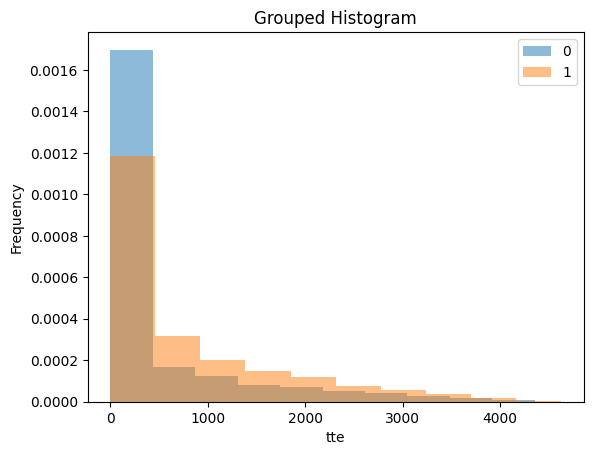

In [10]:
grouped = pats.groupby('death')

# Plot grouped histogram
fig, ax = plt.subplots()
for category, group in grouped:
    ax.hist(group['time_to_event'], label=category, alpha=0.5, bins=10 , density = True)

ax.legend()
plt.xlabel('tte')
plt.ylabel('Frequency')
plt.title('Grouped Histogram')
plt.show()

In [11]:
consolidated_pat_tbl = pd.merge(df_3 , pats , on = 'subject_id' , how = 'inner')

# QC
assert len(consolidated_pat_tbl) == consolidated_pat_tbl.subject_id.nunique() , 'not patient level table'

# name change
consolidated_pat_tbl.rename(columns = {'50907':'cholesterol' , '50983':'sodium' , '51133':'lymphocyte' , '51222':'hemoglobin'} , inplace = True)

In [12]:
# _columns = consolidated_pat_tbl.columns.astype('str')
# consolidated_pat_tbl.columns = _columns

# # Imputation
# imputer = SimpleImputer(strategy = 'most_frequent')
# consolidated_pat_tbl = pd.DataFrame(imputer.fit_transform(consolidated_pat_tbl) , columns = _columns)

# # Check for null
# assert np.round(consolidated_pat_tbl.notnull().sum()/len(consolidated_pat_tbl)).sum() == consolidated_pat_tbl.shape[1]

# # name change
# consolidated_pat_tbl.rename(columns = {'50907':'cholesterol' , '50983':'sodium' , '51133':'lymphocyte' , '51222':'hemoglobin'} , inplace = True)

In [13]:
folder_path = "data/"

# Check if the folder exists
if not os.path.exists(folder_path):
    # Create the folder
    os.makedirs(folder_path)

# Pickle the DataFrame
with open('data/consolidated_pat_tbl.pickle', 'wb') as file:
    pickle.dump(consolidated_pat_tbl, file)